In [1]:
import sys
import scipy.stats
from scipy.signal import coherence
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from trajectory_process import traj_process

import numpy as np
from scipy.cluster import hierarchy
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib notebook
import glob
import re  # Regular expression operations
import pandas as pd
from scipy import signal
import mne
from tqdm import tqdm
import os
from os.path import exists
import pickle
import statsmodels.stats.api as sms

sys.path.append('D:\ephys')

import utils
import ephys
import plotting

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 7
plt.rcParams["font.family"] = "Arial"

mBWfus009 = {
    'arena_0219': '2021-02-19_mBWfus009_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus009_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus009_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus009_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus009_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus009_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus009_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus009_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus009_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus009_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus009_OF_ephys',

    'arena_0325': '2021-03-25_mBWfus009_arena_ephys',
    'epm_0325': '2021-03-25_mBWfus009_EPM_ephys'
}

mBWfus008 = {
    'arena_0219': '2021-02-19_mBWfus008_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus008_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus008_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus008_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus008_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus008_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus008_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus008_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus008_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus008_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus008_OF_ephys',
}

mBWfus010 = {
    'arena_0219': '2021-02-19_mBWfus010_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus010_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus010_OF_ephys',

    'arena_0301_aft': '2021-03-01_mBWfus010_arena_ephys_after',
    'arena_0301_bef': '2021-03-01_mBWfus010_arena_ephys_before',
    'cage_0301': '2021-03-01_mBWfus010_cage_ephys',
    'oft_0301': '2021-03-01_mBWfus010_OF_ephys',
    'ezm_0301': '2021-03-01_mBWfus010_EZM_ephys',

    'arena_0307_bef': '2021-03-07_mBWfus010_after_arena_ephys',
    'cage_0307': '2021-03-07_mBWfus010_cage_arena_ephys',
    'arena_0307_aft': '2021-03-07_mBWfus010_after_arena_ephys',
    'ezm_0307': '2021-03-07_mBWfus010_EZM_ephys',
    'oft_0307': '2021-03-07_mBWfus010_OF_ephys',
}

mBWfus011 = {
    'arena_0226': '2021-02-26_mBWfus011_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus011_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus011_OF_ephys',

    'arena_0305_aft': '2021-03-05_mBWfus011_after_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus011_cage_arena_ephys',
    'arena_0305_bef': '2021-03-05_mBWfus011_before_arena_ephys',
    'oft_0305': '2021-03-05_mBWfus011_OF_ephys',
    'ezm_0305': '2021-03-05_mBWfus011_EZM_ephys',

    'arena_0313_bef': '2021-03-13_mBWfus011_before_arena_ephys',
    'cage_0313': '2021-03-13_mBWfus011_cage_arena_ephys',
    'arena_0313_aft': '2021-03-13_mBWfus011_after_arena_ephys',
    'ezm_0313': '2021-03-13_mBWfus011_EZM_ephys',
    'oft_0313': '2021-03-13_mBWfus011_OF_ephys',
}

mBWfus012 = {
    'arena_0226': '2021-02-26_mBWfus012_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus012_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus012_OF_ephys',
}

mBWfus018 = {
    'epm_0511': '2021-05-11_mBWfus018_EPM_behv'
}

In [2]:
np.random.seed(42)
animal = mBWfus018
session = 'epm_0511'
behavior_trigger = 23.0

D:\ephys\2021-05-11_mBWfus018_EPM_behv\ephys_processed\
total number of frames: 50846
frames to process: 45000
edited 635 data points


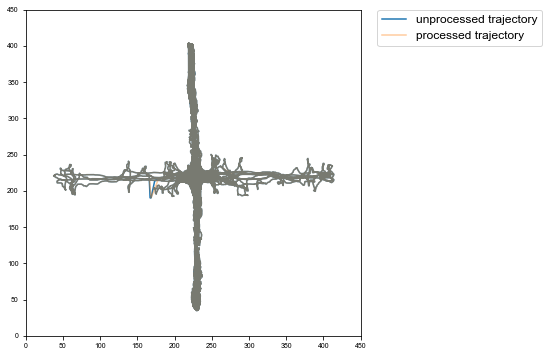

D:\ephys\2021-05-11_mBWfus018_EPM_behv\ephys_processed\EPM_points.pkl loaded
ROIs defined


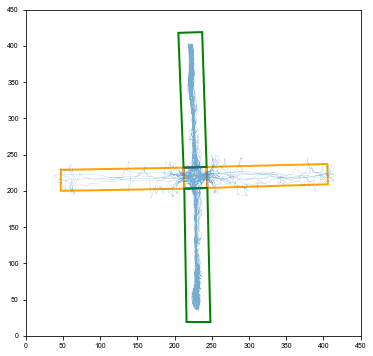

ROIs assigned
Number of open-to-closed crossings detected: 18
Number of closed-to-open crossings detected: 18
Number of nosedips detected: 27


In [3]:
# before running the following code, first copy ‘EPM_points.pkl' to the corresponding ephys_processed directory
f_behavior = 50
f_ephys = 500
behavior_window_duration = 15 * 60
ephys_window_duration = 1000

events = traj_process(animal[session], behavior='epm', start_time=behavior_trigger, duration=behavior_window_duration)
# events = pickle.load(open('D:\\ephys\\2021-02-19_mBWfus009_EZM_ephys\ephys_processed\\2021-02-19_mBWfus009_EZM_ephys_results_manually_annotated.pickle',
#                           "rb"))

### extract overall behavioral open/close frame indices
### selection based on label 'starts with' open/closed because open/closed regions split into two
open_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
            if
            el.startswith('open')]
close_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
             if
             el.startswith('closed')]


In [7]:
exclude_keys = ['roi_at_each_frame', 'cumulative_time_in_roi', 'avg_time_in_roi', 'avg_time_in_roi_sec']
roi_stats = {key: events['rois_stats'][key] for key in events['rois_stats'].keys() if key not in exclude_keys}
roi_stats = pd.DataFrame.from_dict(roi_stats)
roi_stats

,ROI_name,transitions_per_roi,cumulative_time_in_roi_sec,avg_vel_in_roi
0,center,95,137.10,21.667467
1,closedbottom,26,278.78,32.595710
2,closedtop,23,317.30,24.583832
3,nan,2,116.90,0.000000
4,openleft,18,64.42,32.901277
5,openright,29,102.42,30.100049
6,tot,193,1016.92,NaN


In [5]:
### extract overall open-closed crossing events' frame indexes
open_to_close_idx = np.array(events['transitions']['open_closed_entrytime']) - int(f_behavior * behavior_trigger)
close_to_open_idx = np.array(events['transitions']['closed_open_entrytime']) - int(f_behavior * behavior_trigger)

In [6]:
print(len(close_idx), '  ', len(open_idx))

29803    8342
